# 04: Balancing and binning

## Balancing

Problem: We have an instance of some classification problem and our data set is imbalanced, that is, one class has _significantly_ less representants than another class.

In [1]:
import numpy as np
import pandas as pd

from scipy.stats import norm, ttest_ind
from scipy.optimize import minimize_scalar

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_selection import f_regression, mutual_info_regression, RFECV
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_log_error, make_scorer, mean_squared_error
from sklearn import preprocessing

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

### The data

In [2]:
data = pd.read_csv('default_of_credit_card_clients.csv',sep=';') #Yeh, I. C., & Lien, C. H. (2009). The comparisons of data mining techniques for the predictive accuracy of probability of default of credit card clients. Expert Systems with Applications, 36(2), 2473-2480.
data.describe() #data description: see https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X15,X16,X17,X18,X19,X20,X21,X22,X23,class
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,...,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.00000,30000.000000,30000.000000,30000.000000,30000.000000
mean,167484.322667,1.603733,1.853133,1.551867,35.485500,-0.016700,-0.133767,-0.166200,-0.220667,-0.266200,...,43262.948967,40311.400967,38871.760400,5663.580500,5.921163e+03,5225.68150,4826.076867,4799.387633,5215.502567,0.221200
std,129747.661567,0.489129,0.790349,0.521970,9.217904,1.123802,1.197186,1.196868,1.169139,1.133187,...,64332.856134,60797.155770,59554.107537,16563.280354,2.304087e+04,17606.96147,15666.159744,15278.305679,17777.465775,0.415062
min,10000.000000,1.000000,0.000000,0.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,...,-170000.000000,-81334.000000,-339603.000000,0.000000,0.000000e+00,0.00000,0.000000,0.000000,0.000000,0.000000
25%,50000.000000,1.000000,1.000000,1.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,2326.750000,1763.000000,1256.000000,1000.000000,8.330000e+02,390.00000,296.000000,252.500000,117.750000,0.000000
50%,140000.000000,2.000000,2.000000,2.000000,34.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,19052.000000,18104.500000,17071.000000,2100.000000,2.009000e+03,1800.00000,1500.000000,1500.000000,1500.000000,0.000000
75%,240000.000000,2.000000,2.000000,2.000000,41.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,54506.000000,50190.500000,49198.250000,5006.000000,5.000000e+03,4505.00000,4013.250000,4031.500000,4000.000000,0.000000
max,1000000.000000,2.000000,6.000000,3.000000,79.000000,8.000000,8.000000,8.000000,8.000000,8.000000,...,891586.000000,927171.000000,961664.000000,873552.000000,1.684259e+06,896040.00000,621000.000000,426529.000000,528666.000000,1.000000


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 24 columns):
X1       30000 non-null int64
X2       30000 non-null int64
X3       30000 non-null int64
X4       30000 non-null int64
X5       30000 non-null int64
X6       30000 non-null int64
X7       30000 non-null int64
X8       30000 non-null int64
X9       30000 non-null int64
X10      30000 non-null int64
X11      30000 non-null int64
X12      30000 non-null int64
X13      30000 non-null int64
X14      30000 non-null int64
X15      30000 non-null int64
X16      30000 non-null int64
X17      30000 non-null int64
X18      30000 non-null int64
X19      30000 non-null int64
X20      30000 non-null int64
X21      30000 non-null int64
X22      30000 non-null int64
X23      30000 non-null int64
class    30000 non-null int64
dtypes: int64(24)
memory usage: 5.5 MB


In [4]:
data['class'].value_counts()

0    23364
1     6636
Name: class, dtype: int64

In [5]:
class_names = [0,1] # for printing purposes later

## (Binary) classification and its evaluation

In order to evaluate the preprocessing of our data set, we shall use some classifiers as black boxes.

http://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html

/home/ladislav/MI-PDD2018/cv4/__venv__/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/ladislav/MI-PDD2018/cv4/__venv__/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/ladislav/MI-PDD2018/cv4/__venv__/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


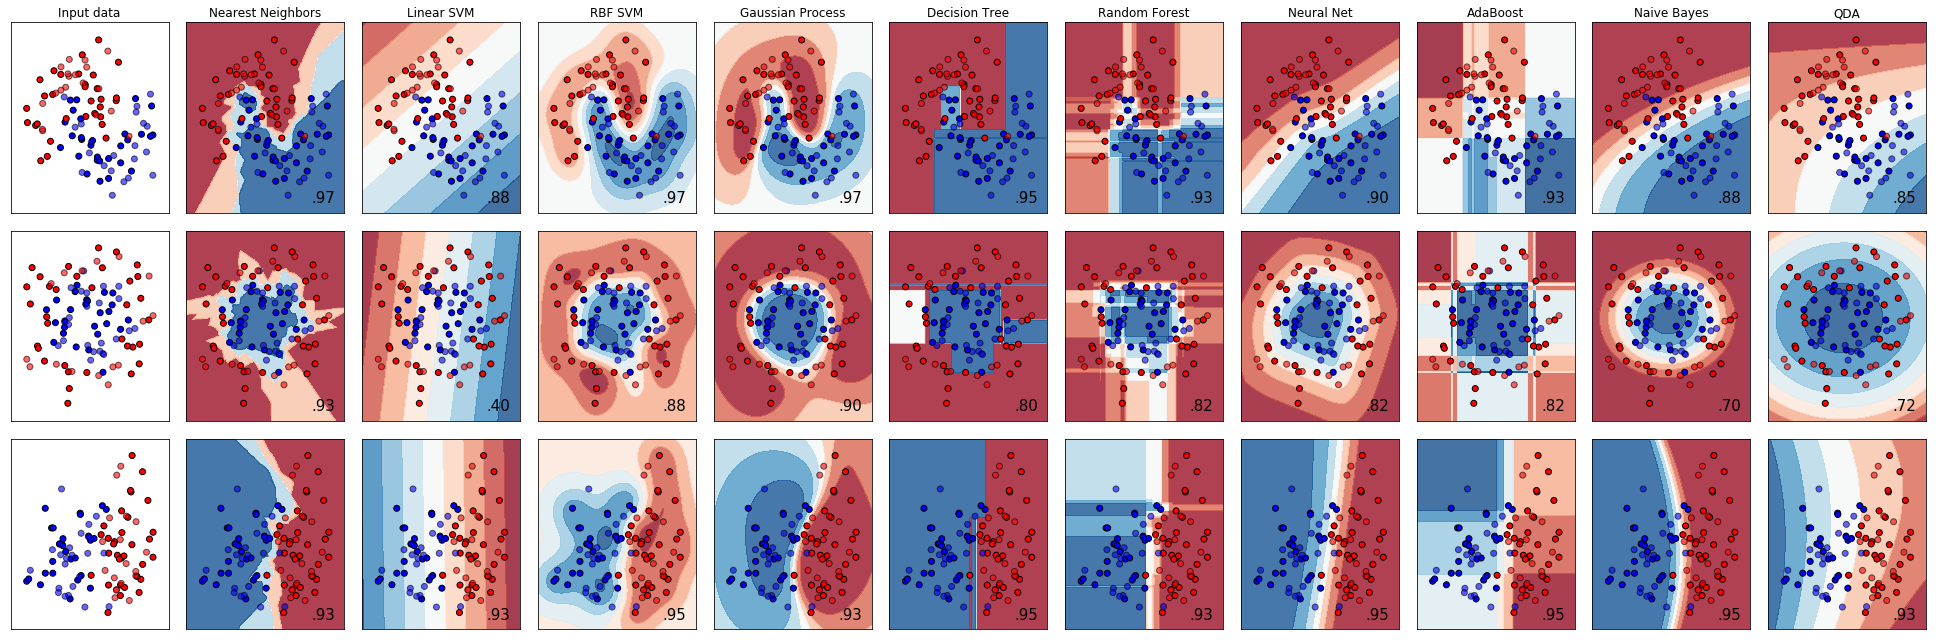

In [6]:
# Code source: Gaël Varoquaux
#              Andreas Müller
# Modified for documentation by Jaques Grobler
# License: BSD 3 clause

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

h = .02  # step size in the mesh

names = ["Nearest Neighbors", "Linear SVM", "RBF SVM", "Gaussian Process",
         "Decision Tree", "Random Forest", "Neural Net", "AdaBoost",
         "Naive Bayes", "QDA"]

classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    GaussianProcessClassifier(1.0 * RBF(1.0)),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis()]

X, y = make_classification(n_features=2, n_redundant=0, n_informative=2,
                           random_state=1, n_clusters_per_class=1)
rng = np.random.RandomState(2)
X += 2 * rng.uniform(size=X.shape)
linearly_separable = (X, y)

datasets = [make_moons(noise=0.3, random_state=0),
            make_circles(noise=0.2, factor=0.5, random_state=1),
            linearly_separable
            ]

figure = plt.figure(figsize=(27, 9))
i = 1
# iterate over datasets
for ds_cnt, ds in enumerate(datasets):
    # preprocess dataset, split into training and test part
    X, y = ds
    X = StandardScaler().fit_transform(X)
    X_train, X_test, y_train, y_test = \
        train_test_split(X, y, test_size=.4, random_state=42)

    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    # just plot the dataset first
    cm = plt.cm.RdBu
    cm_bright = ListedColormap(['#FF0000', '#0000FF'])
    ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
    if ds_cnt == 0:
        ax.set_title("Input data")
    # Plot the training points
    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright,
               edgecolors='k')
    # and testing points
    ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.6,
               edgecolors='k')
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xticks(())
    ax.set_yticks(())
    i += 1

    # iterate over classifiers
    for name, clf in zip(names, classifiers):
        ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
        clf.fit(X_train, y_train)
        score = clf.score(X_test, y_test)

        # Plot the decision boundary. For that, we will assign a color to each
        # point in the mesh [x_min, x_max]x[y_min, y_max].
        if hasattr(clf, "decision_function"):
            Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
        else:
            Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]

        # Put the result into a color plot
        Z = Z.reshape(xx.shape)
        ax.contourf(xx, yy, Z, cmap=cm, alpha=.8)

        # Plot also the training points
        ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright,
                   edgecolors='k')
        # and testing points
        ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright,
                   edgecolors='k', alpha=0.6)

        ax.set_xlim(xx.min(), xx.max())
        ax.set_ylim(yy.min(), yy.max())
        ax.set_xticks(())
        ax.set_yticks(())
        if ds_cnt == 0:
            ax.set_title(name)
        ax.text(xx.max() - .3, yy.min() + .3, ('%.2f' % score).lstrip('0'),
                size=15, horizontalalignment='right')
        i += 1

plt.tight_layout()
plt.show()

The following metrics are commonly used to evaluate the performance of a **binary** classifier (and the underlying data set).

There are 2 classes, positive and negative. The counts of their representantas are denoted $P$ and $N$, respectively.
The results of the classification are given by the following counts:
$$
TP = \text{true positive}, TN = \text{true negative}, FP = \text{false positive}, FN = \text{false negative}.
$$
(That is, $TP+FP$ samples are assigned the positive class by the selected classifier.)

These number are ofter stored in _confusion matrix_ (in Czech often "klasifikační matice"):
$$
C = \begin{pmatrix} TN & FN \\ FP & TP \end{pmatrix}.
$$

More indicators are often used, for instance:
$$
\text{Precision} = \frac{TP}{TP+FP}, \quad \text{Accuracy} = \frac{TP+TN}{P+N}.
$$

(In multiple class problem, these metrics are generalized in a straightforward manner, see for instance http://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html)

In [7]:
# TASK 1: select a classifier above and classify `data` and calculate the confusion matrix of the result; comment the result

from sklearn.metrics import confusion_matrix # http://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html




In [17]:
from sklearn.neighbors import KNeighborsClassifier
clf = KNeighborsClassifier(1)

y = list(data['class'])
X = data.drop(['class'],axis=1)
#X = X.loc[:, X.nunique() < 12]

train_X, test_X, train_Y, test_Y = train_test_split(X, y, test_size=.2, random_state=11)
pred_Y = clf.fit(train_X, train_Y).predict(test_X)


cnf_matrix = confusion_matrix(test_Y, pred_Y)

print(cnf_matrix)












































#######################################################
#######################################################
#######################################################

from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

#clf = GaussianNB()
#clf = SVC(gamma=2, C=1)
#clf = SVC(kernel="linear", C=0.025)

#clf = DecisionTreeClassifier()
clf = BernoulliNB()

y = list(data['class'])
X = data.drop(['class'],axis=1)
#X = X.loc[:, X.nunique() < 12]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.4, random_state=42)
y_pred = clf.fit(X_train, y_train).predict(X_test)

cnf_matrix = confusion_matrix(y_test, y_pred)

print(cnf_matrix)


[[3735  906]
 [ 942  417]]
[[7885 1472]
 [1302 1341]]


Let's plot the confusion matrix (to have some fancy visualisation ...).

In [13]:
from sklearn.metrics import confusion_matrix
import itertools

# taken from http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    #else:
        #print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = (cm.max() + cm.min()) / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

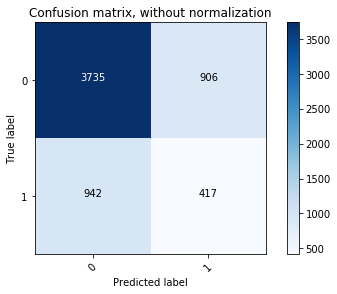

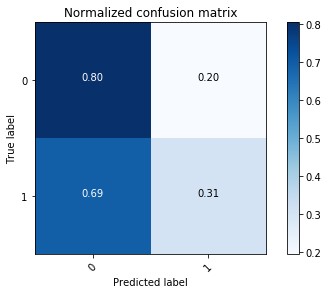

In [19]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(test_Y, pred_Y)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

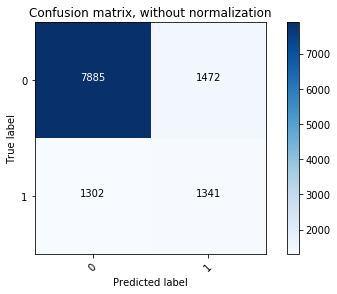

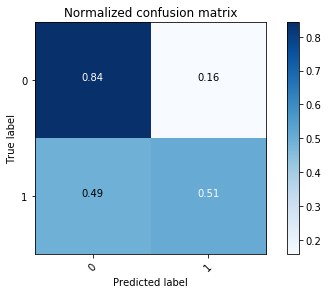

In [16]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [ ]:
# idealne jednicky na diagonale. problem je kdyz je to jednicka.

*Questions*

1. What might be the effect of imbalancedness on the classification?
1. How would you handle imbalanced classes?


























## Handling imbalanced classes

(We still focus on the binary class problem.)

The class with the majority of samples is called the **majority class**, the other is the **minority class**.

The basic strategies are
1. to under-sample the majority class (= to remove some its elements)
1. to over-sample the minority class (= to add some elements to the class)
1. do both of the above
1. do nothing

### Under-sampling


In [11]:
# TASK 2: perform a random undersampling of the majority class and comment on the result



In [24]:



df = data.loc[data['class'] == 0]
df.sample(7000).count()



































######################################
# see below

X1       7000
X2       7000
X3       7000
X4       7000
X5       7000
X6       7000
X7       7000
X8       7000
X9       7000
X10      7000
X11      7000
X12      7000
X13      7000
X14      7000
X15      7000
X16      7000
X17      7000
X18      7000
X19      7000
X20      7000
X21      7000
X22      7000
X23      7000
class    7000
dtype: int64

### Imbalanced-learn

http://contrib.scikit-learn.org/imbalanced-learn/stable/install.html

`pip/pip3 install imbalanced-learn --user [--upgrade]`


http://contrib.scikit-learn.org/imbalanced-learn/stable/generated/imblearn.under_sampling.RandomUnderSampler.html

Counter({0: 6636, 1: 6636})


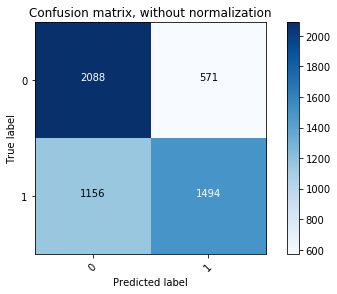

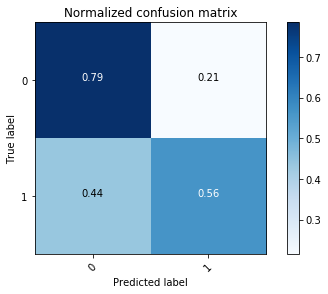

In [25]:
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(random_state=42)

X_res, y_res = rus.fit_sample(X, y)
print(Counter(y_res))

X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=.4, random_state=42)
y_pred = clf.fit(X_train, y_train).predict(X_test)
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')


# Neni potreba undersamplink pro testovaci data. Nutne pro trenovaci data.

## Under-sampling methods

- Randon under-sampling
- Condensed nearest neighbour (CNN)
- (Wilson's) Edited Nearest Neigbour (ENN)
- Neigbourhood Cleaning Rule (NCL)
- One-side Sampling (OSS)
- Tomek Links

http://contrib.scikit-learn.org/imbalanced-learn/stable/api.html#module-imblearn.under_sampling

#### Tomek links

Let $x$ and $y$ be two samples of distinct class.
If there is no sample $z$ such that
$$
\rm{d}(x, z) < \rm{d}(x, y) \quad \text{ or } \quad \rm{d}(y, z) < \rm{d}(x, y),
$$
where $\rm d$ is **the distance** between the two samples, we say there is a **Tomek link** between $x$ and $y$.

In other words, a Tomek’s link exists if the two samples of distinct class are the nearest neighbors of each other.
See the illustration at https://imbalanced-learn.readthedocs.io/en/stable/under_sampling.html#tomek-links

We can choose various strategies how to resample the data using Tomek links, for instance, we might remove all majority samples which are paired by the link with a minority sample.

In [14]:
### Task 3 - Try it!

*Question*

1. How can we visualize the removed samples if the data is multidimensional?

(13272, 5)
Counter({0: 6636, 1: 6636})


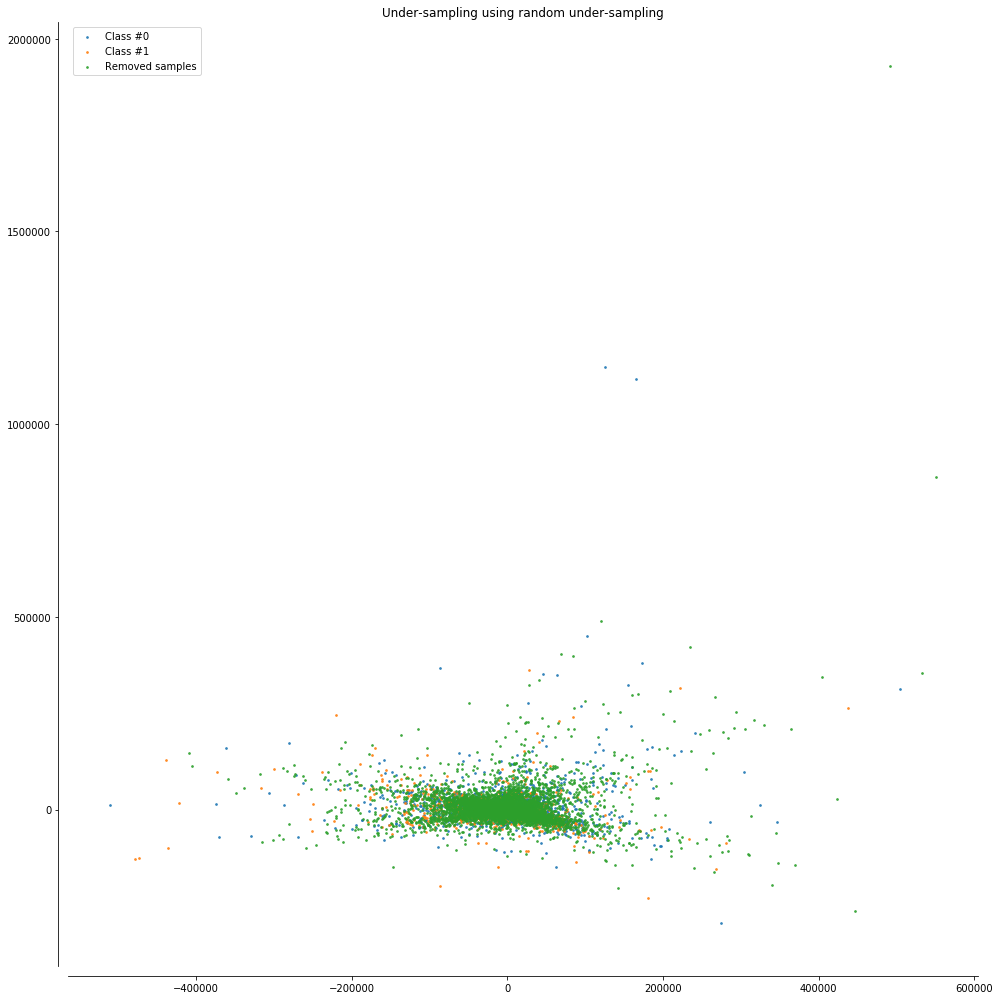

Counter({0: 21555, 1: 6636})


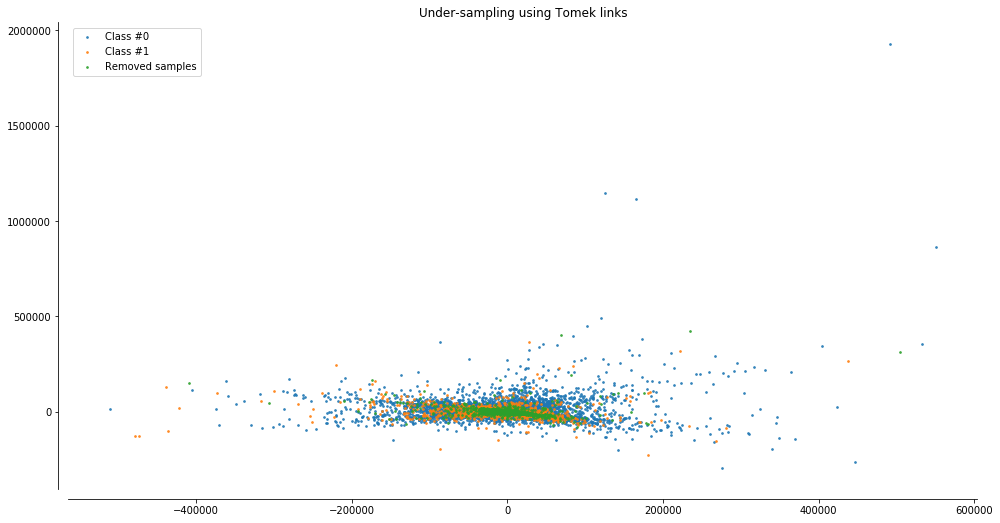

In [15]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_classification
from sklearn.decomposition import PCA

from imblearn.under_sampling import RandomUnderSampler
from imblearn.under_sampling import TomekLinks

from collections import Counter

y = list(data['class'])
X = data.drop(['class'],axis=1)

# Instanciate a PCA object for the sake of easy visualisation
pca = PCA(n_components=5)
# Fit and transform x to visualise inside a 2D feature space
X_vis = pca.fit_transform(X)

# Apply the random under-sampling
rus = RandomUnderSampler(return_indices=True)
X_resampled, y_resampled, idx_resampled = rus.fit_sample(X, y)
X_res_vis = pca.transform(X_resampled)
print(X_res_vis.shape)

print(Counter(y_resampled))

fig = plt.figure(figsize=(14, 14))
ax = fig.add_subplot(1, 1, 1)

idx_samples_removed = np.setdiff1d(np.arange(X_vis.shape[0]),
                                   idx_resampled)

idx_class_0 = y_resampled == 0
_size = 3

# selection of PCA components
x_comp = 2
y_comp = 3

# plot
plt.scatter(X_res_vis[idx_class_0, x_comp], X_res_vis[idx_class_0, y_comp],
            alpha=.8, s=_size, label='Class #0')
plt.scatter(X_res_vis[~idx_class_0, x_comp], X_res_vis[~idx_class_0, y_comp],
            alpha=.8, s=_size, label='Class #1')
plt.scatter(X_vis[idx_samples_removed, x_comp], X_vis[idx_samples_removed, y_comp],
            alpha=.8, s=_size, label='Removed samples')

# make nice plotting
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.get_xaxis().tick_bottom()
ax.get_yaxis().tick_left()
ax.spines['left'].set_position(('outward', 10))
ax.spines['bottom'].set_position(('outward', 10))
#ax.set_xlim([-6, 6])
#ax.set_ylim([-6, 6])

plt.title('Under-sampling using random under-sampling')
plt.legend()
plt.tight_layout()
plt.show()


# Apply the tomek link undersampler
tl = TomekLinks(return_indices=True)
X_resampled, y_resampled, idx_resampled = tl.fit_sample(X, y)
X_res_vis = pca.transform(X_resampled)

print(Counter(y_resampled))

fig = plt.figure(figsize=(14, 14))
ax = fig.add_subplot(2, 1, 1)

idx_samples_removed = np.setdiff1d(np.arange(X_vis.shape[0]),
                                   idx_resampled)

idx_class_0 = y_resampled == 0
_size = 3

plt.scatter(X_res_vis[idx_class_0, x_comp], X_res_vis[idx_class_0, y_comp],
            alpha=.8, s=_size, label='Class #0')
plt.scatter(X_res_vis[~idx_class_0, x_comp], X_res_vis[~idx_class_0, y_comp],
            alpha=.8, s=_size, label='Class #1')
plt.scatter(X_vis[idx_samples_removed, x_comp], X_vis[idx_samples_removed, y_comp],
            alpha=.8, s=_size, label='Removed samples')

# make nice plotting
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.get_xaxis().tick_bottom()
ax.get_yaxis().tick_left()
ax.spines['left'].set_position(('outward', 10))
ax.spines['bottom'].set_position(('outward', 10))
#ax.set_xlim([-6, 6])
#ax.set_ylim([-6, 6])

plt.title('Under-sampling using Tomek links')
plt.legend()
plt.tight_layout()
plt.show()

### Over-sampling methods

- random over-sampling
- Synthetic Minority Over-sampling Technique (SMOTE)
- ...

https://imbalanced-learn.org/en/stable/api.html#module-imblearn.over_sampling

#### SMOTE

SMOTE inserts new samples based on the following idea: having selected a sample $x$ from the minority class, find its $k$ nearest neighbors, connect them and $x$ by a line, and then pick new samples ranndomly on each line.

<img src="smote.png">

https://imbalanced-learn.org/en/stable/over_sampling.html#mathematical-formulation

<!--
http://contrib.scikit-learn.org/imbalanced-learn/stable/auto_examples/over-sampling/plot_smote.html#sphx-glr-auto-examples-over-sampling-plot-smote-py
-->

In [16]:
### Task 4 - try various under and over-sampling methods on data

Random under-sampling
CPU times: user 72 ms, sys: 4 ms, total: 76 ms
Wall time: 79 ms
Counter({0: 6636, 1: 6636})


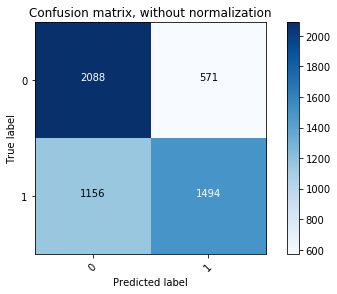

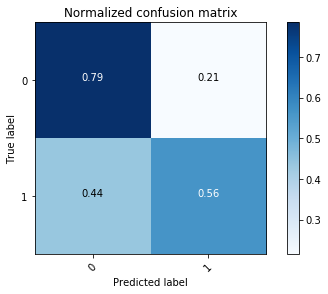

Tomek Links
CPU times: user 12.1 s, sys: 60 ms, total: 12.1 s
Wall time: 12.2 s
Counter({0: 21555, 1: 6636})


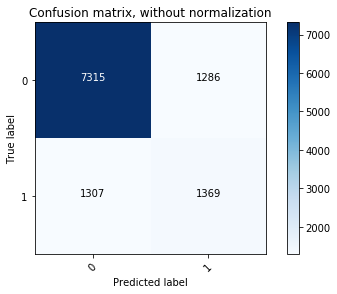

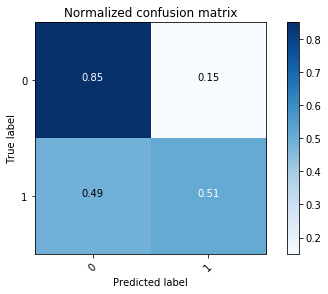

ENN
CPU times: user 12.4 s, sys: 40 ms, total: 12.4 s
Wall time: 12.5 s
Counter({0: 12786, 1: 6636})


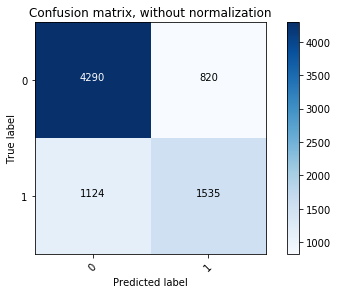

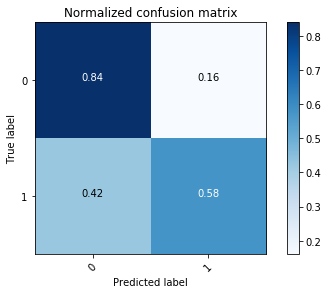

CNN
CPU times: user 15.6 s, sys: 228 ms, total: 15.9 s
Wall time: 16.5 s
Counter({0: 21556, 1: 6636})


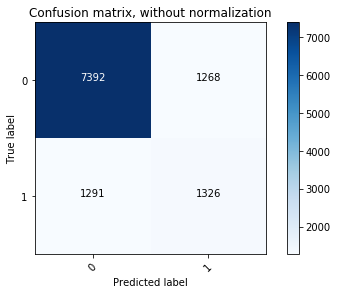

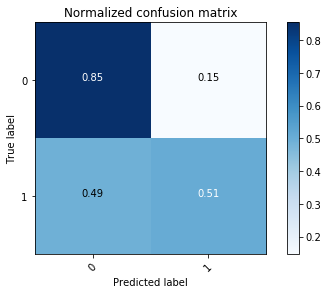

SMOTE
CPU times: user 1.94 s, sys: 128 ms, total: 2.06 s
Wall time: 2.27 s
Counter({1: 23364, 0: 23364})


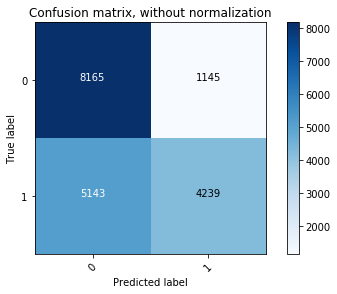

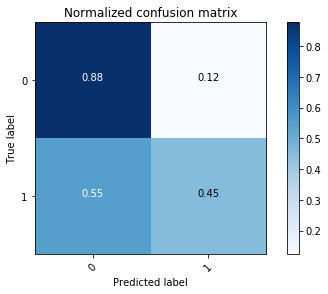

SMOTEENN
CPU times: user 24.3 s, sys: 668 ms, total: 25 s
Wall time: 26.6 s
Counter({1: 17029, 0: 10376})


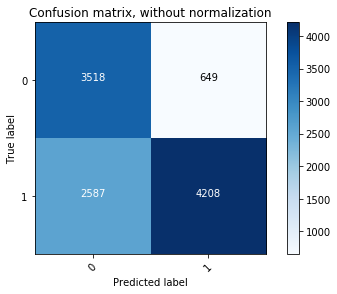

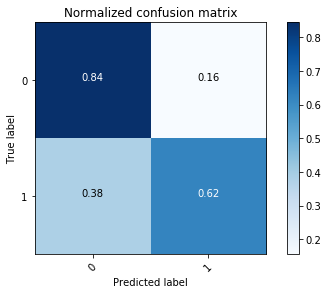

In [26]:
from collections import Counter

from imblearn.under_sampling import CondensedNearestNeighbour
from imblearn.under_sampling import RandomUnderSampler
from imblearn.under_sampling import TomekLinks
from imblearn.under_sampling import EditedNearestNeighbours
from imblearn.under_sampling import OneSidedSelection 
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN


#clf = GaussianNB()
#clf = DecisionTreeClassifier()
clf = BernoulliNB()

y = list(data['class'])
X = data.drop(['class'],axis=1)


resamplers = [
    (RandomUnderSampler(random_state=42),'Random under-sampling'),
    (TomekLinks(random_state=42),'Tomek Links'),
    #(CondensedNearestNeighbour(random_state=42),'CNN'),
    (EditedNearestNeighbours(random_state=42),'ENN'),
    (OneSidedSelection(random_state=42),'CNN'),
    (SMOTE(random_state=42),'SMOTE'),
    (SMOTEENN(random_state=42),'SMOTEENN'),  
]

for resampler,description in resamplers:
    print(description)
    %time X_res, y_res = resampler.fit_sample(X, y)
    print(Counter(y_res))
    
    X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=.4, random_state=42)
    
    y_pred = clf.fit(X_train, y_train).predict(X_test)
    
    
    # Compute confusion matrix
    cnf_matrix = confusion_matrix(y_test, y_pred)
    np.set_printoptions(precision=2)

    # Plot non-normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=class_names,
                          title='Confusion matrix, without normalization')

    # Plot normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                          title='Normalized confusion matrix')
    
    
    plt.show()



## Model validation revisited

Our validation method is very simple.
The following should/may be considered:
1. Use a cross-validation technique [homework?]
1. Use other validation metrics (this strongly depends on the task in hand) (see https://imbalanced-learn.org/en/stable/api.html#module-imblearn.metrics or https://en.wikipedia.org/wiki/Matthews_correlation_coefficient) [see below]
1. Look deeper in what the classifier has to say ([ROC](https://en.wikipedia.org/wiki/Receiver_operating_characteristic), Lift etc. + AUC (Area under curve)) [see below]
1. Test the data on an raw imbalanced set [homework]
1. ...



#### ROC curve

To have a meaningful ROC curve, we need a classifier which is capable of outputting a prediction of probability that a sample is in the give class.

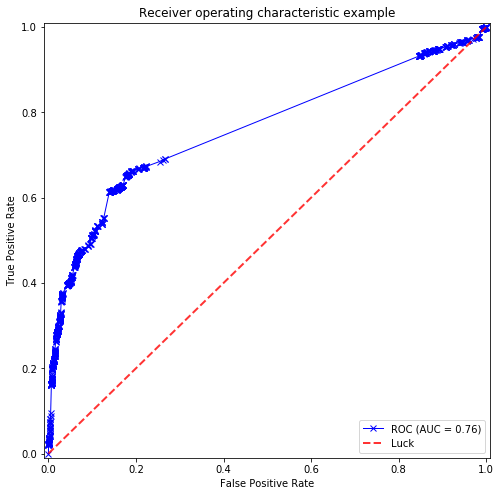

In [27]:
from sklearn.metrics import roc_curve, auc

# clf = DecisionTreeClassifier()
clf = BernoulliNB()

X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=.4, random_state=42)

probas_ = clf.fit(X_train, y_train).predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1])
#tprs.append(interp(mean_fpr, fpr, tpr))
#tprs[-1][0] = 0.0
roc_auc = auc(fpr, tpr)
#aucs.append(roc_auc)
plt.figure(figsize=(8,8))
plt.plot(fpr, tpr, lw=1, alpha=1, label='ROC (AUC = %0.2f)' % (roc_auc),color='b', marker='x')
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Luck', alpha=.8)

plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()
# y^ = 1, p(y|x)>= q
# koukam se p5i posouv8n9 hrranice pravdepodobnosti do jednotlivych trid, proste se mi zvysuje chyba s posunem hranic. 
# q = 1 obe nula, apk sleduju jak se to prelejva az k jednicce = kde maji 100 procent, 
# deli se t skutecnosti a normalizovany skutecnosti vlastne.

The dependence on the splitting of the set may be lowered by running multiple tests (in the spirit of cross-validation).

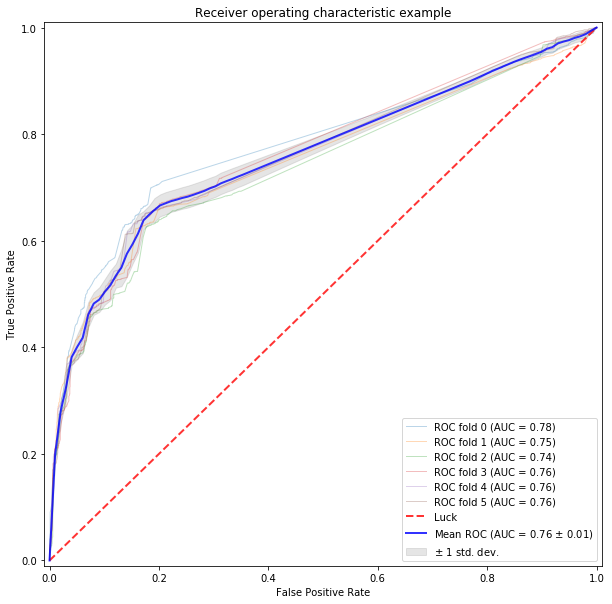

In [28]:
from scipy import interp
from itertools import cycle
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold

# #############################################################################
# Classification and ROC analysis

# Run classifier with cross-validation and plot ROC curves
cv = StratifiedKFold(n_splits=6)

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)
plt.figure(figsize=(10,10))

# clf = DecisionTreeClassifier()
clf = BernoulliNB()

i = 0
for train, test in cv.split(X_res, y_res):
    probas_ = clf.fit(X_res[train], y_res[train]).predict_proba(X_res[test])
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y_res[test], probas_[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=1, alpha=0.3,
             label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

    i += 1
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Luck', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
         label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
         lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                 label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()


Metrics from imbalanced learn package

http://contrib.scikit-learn.org/imbalanced-learn/stable/generated/imblearn.metrics.classification_report_imbalanced.html

In [29]:
from sklearn import datasets
from sklearn.model_selection import train_test_split

from imblearn import over_sampling as os
from imblearn import pipeline as pl
from imblearn.metrics import classification_report_imbalanced

RANDOM_STATE = 42

pipeline = pl.make_pipeline(os.SMOTE(random_state=RANDOM_STATE),
                            BernoulliNB())

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=RANDOM_STATE)

# Train the classifier with balancing
pipeline.fit(X_train, y_train)

# Test the classifier and get the prediction
y_pred_bal = pipeline.predict(X_test)

# Show the classification report
print(classification_report_imbalanced(y_test, y_pred_bal))

                   pre       rec       spe        f1       geo       iba       sup

          0       0.85      0.85      0.48      0.85      0.64      0.42      5873
          1       0.47      0.48      0.85      0.48      0.64      0.39      1627

avg / total       0.77      0.77      0.56      0.77      0.64      0.42      7500



## Binning

Binning is a very common discretization techique:
1. select bins $B_i$ covering (disjointly) the range of a feature $x$
1. create the discretized feature with the value $v_i$ if $x \in B_i$

Usual choices of the bins:
1. equal width (the bins have the same size)
1. equal depth (the bins contain the same number of elements)

https://pandas.pydata.org/pandas-docs/stable/generated/pandas.cut.html

https://pandas.pydata.org/pandas-docs/stable/generated/pandas.qcut.html

## Final remarks

### References

1. https://machinelearningmastery.com/tactics-to-combat-imbalanced-classes-in-your-machine-learning-dataset/
1. https://svds.com/learning-imbalanced-classes/
1. [Tomas Borovicka, Marcel Jirina Jr., Pavel Kordik and Marcel Jirina, _Selecting Representative Data Sets_](https://www.intechopen.com/books/advances-in-data-mining-knowledge-discovery-and-applications/selecting-representative-data-sets)
1. [Vuk, Curk: _ROC Curve, Lift Chart and Calibration Plot_](http://www.stat.wvu.edu/~jharner/courses/dsci503/docs/vuk.pdf)
1. [Elhassan T, Aljurf M, Al-Mohanna F, and Shoukri M:_Classification of Imbalance Data using Tomek Link (T-Link) Combined with Random Under-sampling (RUS) as a Data Reduction Method_](https://pdfs.semanticscholar.org/6ec4/18f9071f3a96d5548e87e34be3665703119e.pdf?_ga=2.37521248.1702047165.1541793547-736740435.1531120151)

## Finishing the task (a.k.a homework)

Try to improve the performance of a classifier on `data` with the following conditions:

1. use binning (on features of your choice, with your choice of parameters) and comment on its effects on classification
1. use at least 2 other preprocessing techniques (your choice!) on the data set and comment the classification results
1. run all classification test at least twice - once for unbalanced original data, once for balanced data (choose a balancing technique), compare those results (give a comment)